In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import partial

import haiku as hk # DeepMind's neural network library
import optax # Gradient-based optimization in JAX

from probjax.utils.odeint import odeint
from probjax.nn.transformers import Transformer
from probjax.nn.helpers import GaussianFourierEmbedding
from probjax.nn.loss_fn import denoising_score_matching_loss
from probjax.distributions.sde import VPSDE, VESDE
from probjax.distributions import Empirical, Independent

from scoresbibm.utils.plot import use_style

from sbi.analysis import pairplot
import numpy as np

In [3]:
from scoresbibm.tasks import LinearGaussian, MixtureGaussian, TwoMoons, SLCP, NonlinearGaussianTreeAllConditionalTask, NonlinearMarcovChainAllConditionalTask

In [4]:
task1 = LinearGaussian(backend="jax")
task2 = MixtureGaussian(backend="jax")
task3 = TwoMoons(backend="jax")
task4 = SLCP(backend="jax")
task5 = NonlinearGaussianTreeAllConditionalTask(backend="jax")
task6 = NonlinearMarcovChainAllConditionalTask(backend="jax")

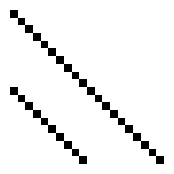

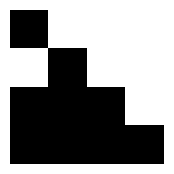

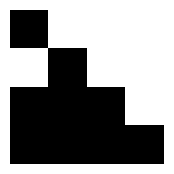

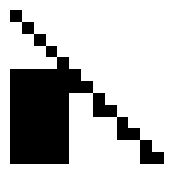

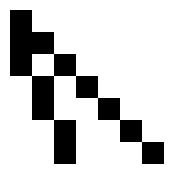

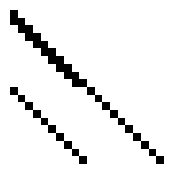

In [17]:
for t in [task1, task2, task3, task4, task5, task6]:
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(t.get_base_mask_fn()(t.get_node_id(), None), cmap="gray_r", vmin=0, vmax=1)
    plt.axis("off")
    plt.show()

In [6]:
gaussian_linear_mask = task1.get_base_mask_fn()(task1.get_node_id(), None)
slcp_mask = task4.get_base_mask_fn()(task4.get_node_id(), None)
tree_mask = task5.get_base_mask_fn()(task5.get_node_id(), None)
hmm_mask = task6.get_base_mask_fn()(task6.get_node_id(), None)
two_moons_mask = task3.get_base_mask_fn()(task3.get_node_id(), None)

In [66]:
from scoresbibm.utils.edge_masks import get_edge_mask_fn


edge_mask_fn_slcp = get_edge_mask_fn("min_faithfull",task6)

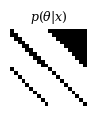

In [95]:
with use_style("pyloric"):
    fig  = plt.figure(figsize=(1,1))
    plt.imshow(edge_mask_fn_slcp(task6.get_node_id(), jnp.array([0]*10+ [1]*10, dtype=bool)), cmap="gray_r")
    plt.axis("off")
    plt.title(r"$p(\theta|x)$")
    plt.savefig("directed_posterior_mask_hmm.svg", bbox_inches="tight")

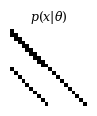

In [94]:
with use_style("pyloric"):
    fig  = plt.figure(figsize=(1,1))
    plt.imshow(edge_mask_fn_slcp(task6.get_node_id(), jnp.array([1]*10+ [0]*10, dtype=bool)), cmap="gray_r")
    plt.axis("off")
    plt.title(r"$p(x|\theta)$")
    plt.savefig("directed_likelihood_mask_hmm.svg", bbox_inches="tight")

In [7]:
# Set random key
key = jax.random.PRNGKey(0)

In [8]:
def connected_by_path_of_length_n(edge_mask, n):
    for _ in range(n):
        edge_mask = jnp.matmul(edge_mask, edge_mask)
    
    return edge_mask > 0

In [10]:
markovian = jnp.eye(100) + jnp.eye(100, k=-1)
parameter_iid = jnp.block([[jnp.eye(100), jnp.zeros((100, 100))], [jnp.eye(100), markovian]])

In [11]:
parameter_iid_undirected = parameter_iid + parameter_iid.T

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


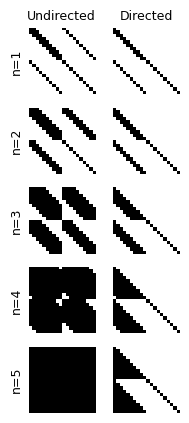

In [14]:
with use_style("pyloric"):
    fig, axes = plt.subplots(5, 2, figsize=(2,5))
    axes[0,0].imshow(connected_by_path_of_length_n(hmm_mask + hmm_mask.T, 0), vmin=0., vmax=1., cmap="Greys")

    axes[1,0].imshow(connected_by_path_of_length_n(hmm_mask + hmm_mask.T, 1), vmin=0., vmax=1., cmap="Greys")

    axes[2,0].imshow(connected_by_path_of_length_n(hmm_mask + hmm_mask.T, 2), vmin=0., vmax=1., cmap="Greys")

    axes[3,0].imshow(connected_by_path_of_length_n(hmm_mask + hmm_mask.T, 3), vmin=0., vmax=1., cmap="Greys")

    axes[4,0].imshow(connected_by_path_of_length_n(hmm_mask + hmm_mask.T, 4), vmin=0., vmax=1., cmap="Greys")


    axes[0,1].imshow(connected_by_path_of_length_n(hmm_mask, 0), vmin=0., vmax=1., cmap="Greys")

    axes[1,1].imshow(connected_by_path_of_length_n(hmm_mask, 1), vmin=0., vmax=1., cmap="Greys")

    axes[2,1].imshow(connected_by_path_of_length_n(hmm_mask, 2), vmin=0., vmax=1., cmap="Greys")

    axes[3,1].imshow(connected_by_path_of_length_n(hmm_mask, 3), vmin=0., vmax=1., cmap="Greys")

    axes[4,1].imshow(connected_by_path_of_length_n(hmm_mask, 4), vmin=0., vmax=1., cmap="Greys")
    
    for i in range(5):
        for j in range(2):
            axes[i,j].spines['left'].set_visible(False)
            axes[i,j].spines['bottom'].set_visible(False)
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
    
    
    axes[0,0].set_title("Undirected")
    axes[0,1].set_title("Directed")
    # Enable y-labels
    axes[0,0].set_ylabel("n=1")
    axes[1,0].set_ylabel("n=2")
    axes[2,0].set_ylabel("n=3")
    axes[3,0].set_ylabel("n=4")
    axes[4,0].set_ylabel("n=5")
    fig.savefig("hmm_mask_per_layer")
    

(-0.5, 12.5, 12.5, -0.5)

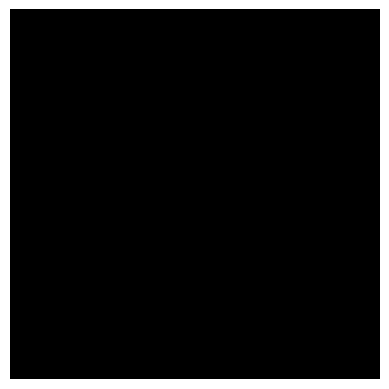

In [13]:
plt.imshow(connected_by_path_of_length_n(slcp_mask + slcp_mask.T, 1), vmin=0., vmax=1., cmap="gray_r")
plt.axis("off")

In [1]:
plt.imshow(connected_by_path_of_length_n(slcp_mask, 0), vmin=0., vmax=1., cmap="gray_r")
plt.axis("off")

NameError: name 'plt' is not defined

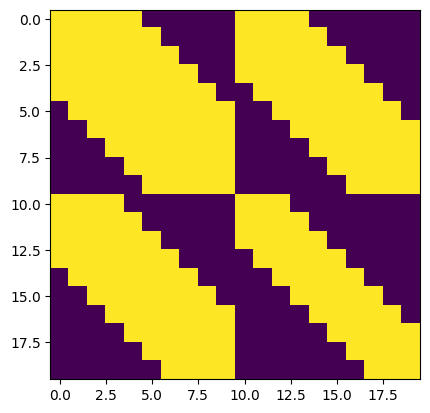

In [227]:
plt.imshow(connected_by_path_of_length_n(hmm_mask + hmm_mask.T, 2))